# Data Mining Cup 2016
## Considerations
### Language Choice
We didn't want to use visual tools like IBM SPS Modeller or KNIME as we don't have the necessary control over the dataprocessing. This leaves Python and R. Because we haven't done anything in R and it has a steep learning curve, we choose Python.

### Jupyter Notebook

We use Jupyter Notebook 4.2 with a python 3.5.1 kernel. Installed by:  
`sudo apt-get install python3-pip`  
`sudo pip3 install ipython`

### Imports

In [7]:
import pandas as pd
import matplotlib
import holidays
import seaborn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
seaborn.set()

## Data
### Import Data

In [26]:
data = pd.read_csv('orders_train.txt',sep = ';')
test_data = pd.read_csv('orders_class.txt', sep = ';')

### Rough Data Analysis

In [17]:
data.describe(percentiles=[]).fillna(0).transpose()

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


count         mean          std     min      50%      max
colorCode       2325165.0  2148.216467  1740.827036  1000.0  1493.00  8888.00
productGroup    2324814.0     5.958604     6.063121     1.0     0.00    90.00
quantity        2325165.0     0.995543     0.164028     0.0     1.00    24.00
price           2325165.0    35.399105    22.662477     0.0    29.99   623.76
rrp             2324814.0    42.985147    24.011038     0.0     0.00   799.99
voucherAmount   2325165.0     2.153040     6.537824     0.0     0.00   300.00
deviceID        2325165.0     2.462385     0.848023     1.0     2.00     5.00
returnQuantity  2325165.0     0.521408     0.503670     0.0     1.00     5.00

In [18]:
data.describe(percentiles=[], include=['O']).fillna('').transpose()

count  unique         top     freq
orderID        2325165  738698    a1602669       46
orderDate      2325165     638  2014-07-29     9957
articleID      2325165    3823    i1003278    26208
sizeCode       2325165      29          38   395163
voucherID      2325159     670           0  1868227
customerID     2325165  311369    c1070653     1256
paymentMethod  2325165      10        BPRG  1810036

### Target Variable
The returnQuantity attribute is to be predicted by the classifier. As can be seen in the plot below, a large number of the orders feature no returns or the return of 1 item. Therefore we consider the problem of predicting the return quantity as a classification problem. An additional reason for modeling the problem as classification is that the final prediction must be a natural number.

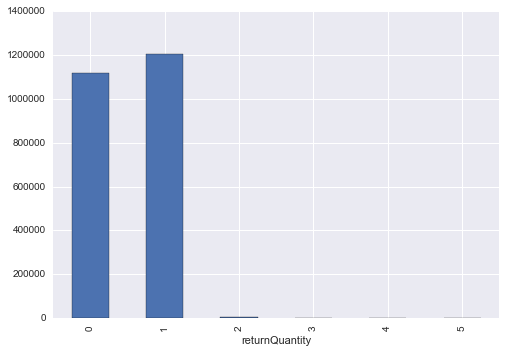

In [19]:
d = data.groupby('returnQuantity').size()
#print(d)
d.plot(kind='bar')

### Data Abnomalies
#### N/A-Values
The article with the id "1004001" has almost all N/A-values. It seems to be a dummy product.
TODO nur voucherID anzeigen

In [5]:
data.isnull().sum() != data[data['articleID'] == "i1004001"].isnull().sum()

orderID           False
orderDate         False
articleID         False
colorCode         False
sizeCode          False
productGroup      False
quantity          False
price             False
rrp               False
voucherID          True
voucherAmount     False
customerID        False
deviceID          False
paymentMethod     False
returnQuantity    False
dtype: bool

As only the voucherID is the only feature, we want to see which articles are affected
TODO: bin zu dumm

In [23]:
data['articleID'](data['voucherID'].isnull())

TypeError: 'Series' object is not callable

In [ ]:
data[data['voucherID'].isnan() & data['articleID'] != "i1004001"]

### Quantity < returnQuantity
Another abnomaly is that some customer can return more from the same order than they ordered. Also we can see that we should hard code if price and quantity is zero, we should predict a returnQuantity of 0.

In [ ]:
data.groupby(['price', 'quantity', 'returnQuantity']).size()

## Features
We define in the follow python methodes which take the data set and return features. In the next step the methodes will used for feature set generation.

#### orderID
The orderID is just the identificator for the observations. It has no use for the classification.

### paymentMethod
The payment method presents an interesting feature. Most of the payment methods have a significantly lower share of returned items. However, one of the most commonly used methods, BPRG, has a higher share on returned items. For our classifier, we have broken up this feature into separate boolean features for each payment type. Each one of these is true if the payment was made using the corresponding method. For example if an order was paid for using PayPal the boolean feature for PAYPALVC will have the value 1 and the boolean features for the rest of the payment methods will have the value 0. The features are calculated as follows:

#### Basket length

In [ ]:
def prepare_basket_length(data):
	orders = data.groupby('orderID').size()
	df = data.join(DataFrame(orders), on='orderID')
	baskets = df[0]
	baskets = (baskets-baskets.mean())/baskets.std()

	d = np.ndarray(shape=(data.shape[0], 1))
	d[:,0]= baskets

	return d, ["basketLength"]

#### Price
The higher the price is the higher the the propability of a returned package.

In [ ]:
def feature_price(data):
    d = np.asarray(pd.to_numeric(data['price']) - np.mean(data['price']) )/ np.std(data['price'])
    return d, ["price"]

#### Recomande retail price
Again the feature on its own doesn't help but we will use it in combination with the price feature.

In [ ]:
def feature_rrp(data):
    data['rrp'] = data['rrp'].fillna(data['price'])
    d = np.asarray((pd.to_numeric(data['rrp']) - np.mean(data['rrp'])) / np.std(data['rrp']))
    return d, ["rrp"]

#### Price-RRP-Ratio
The lower the difference between the price and the rrp is, the better the deal was for the consumer.

In [ ]:
def feature_price_rrp_ratio(data):
    data['price_rrp_ratio'] = np.max(data['price'] - data['rrp'], 0)
    d = pd.to_numeric(((data['price_rrp_ratio']) - np.mean(data['price_rrp_ratio'])) / np.std(data['price_rrp_ratio']))
    return d, ["price_rrp_ratio"]

#### Voucher used


In [ ]:
def feature_voucher_used(data):
    d = np.asarray(data['voucherAmount'] > 0)
    return d, ["voucherUsed"]

#### Voucher amount
The amount of the voucher can also be helpful in the prediction of the return quantity. In our classifier we use a normalized version of this feature. The new feature is calculated as follows:

In [ ]:
def feature_voucher_amount(data):
    d = np.asarray(pd.to_numeric(data['voucherAmount']) - np.mean(data['voucherAmount'])) / np.std(data['voucherAmount'])
    return d, ["voucherAmount"]

#### productGroup
The feature seems to help predict the returnQuantity. The missing values are not important, as already said they belong only to one specific article.

In [ ]:
def productGroup_feature(data):
    # load all data to get all productGroups
    train_data = pd.read_csv('orders_train.txt', sep=';')
    test_data = pd.read_csv('orders_class.txt', sep=';')
    # make list of unique productGroup
    all_data = pd.concat([ train_data, test_data])
    uniPG = all_data['productGroup'].unique()
    # generate productGroup features and names
    productGroupNP = np.zeros([data.shape[0],uniPG.shape[0]])
    names = []
    for u in np.arange(uniPG.shape[0]):
        productGroupNP[:,u] = data['productGroup'].isin([uniPG[u]])
        names.append("productGroup_" + str(uniPG[u]) )
    return productGroupNP, names

#### orderDate
The orderDate as is doesn't help with the classification task, but derived features might.

In [ ]:
data['orderDate']= pd.to_datetime(data['orderDate'], format='%Y-%m-%d')

#### articleID
Just like the orderDate the articleID doesn't help directly, but combined with the features colorCode and sizeCode it might.

In [ ]:
data['articleID'] = data['articleID'].str.replace('i', '')
data['articleID'] = pd.to_numeric(data['articleID'])

#### sizeCode
The problem with the sizeCode is that there are various scales for different regions which overlap. 

In [ ]:
data['sizeCode'].value_counts()

#### quantity
The more one customer orders, the more propable it is, that something gets returned.

In [ ]:
data['quantity'] = pd.to_numeric(data['quantity'])

for i in range(0,5):
    data['quantity_' + str(i)] = data['quantity'] == i #write directly in new numpy-array
    
data['quantity_5'] = data['quantity'] >= 5  #quantities over 5 are summarized

In [ ]:
quantities = data.groupby('quantity').size()
d = data.groupby(['quantity', 'returnQuantity']).size()
d = d.unstack('quantity').fillna(0)
(d/quantities).plot(figsize=(10,10))

#### price
The higher the price is the higher the the propability of a returned package.

In [ ]:
data['price'] = pd.to_numeric(data['price'])
data['price'] = (data['price'] - np.mean(data['price'])) / np.std(data['price'])

### rrp
Again the feature on its own doesn't help but we will use it in combination with the price feature.

In [ ]:
data['rrp'] = pd.to_numeric(data['rrp'])
data['rrp'] = (data['rrp'] - np.mean(data['rrp'])) / np.std(data['rrp'])
data['rrp'].fillna(data['price'])

### voucherID
+ The data set features a number of different voucher IDs. These are used in different orders and are in this sense not unique for the data set.
+ We use the feature if a voucher is used or not. This feature is derived from the absence of a voucher ID.

### voucherAmount
The amount of the voucher can also be helpful in the prediction of the return quantity. In our classifier we use a normalized version of this feature. The new feature is calculated as follows:

In [ ]:
data['voucherAmount'] = (data['voucherAmount'] - data['voucherAmount'].mean()) / data['voucherAmount'].std()

### customerID
As with the articleID the feature itself is useless but derived features based on it will help.

### deviceID
The device type is also an intersting feature for the classification. The main points that can be infered from the plot below are:
+ Items ordered from a device with ID 1 are significantly more likely to be returned than items ordered from other device types
+ The other device types are rather not that helpful in the prediction.

In [ ]:
devices = data.groupby('deviceID').size()
d = data.groupby(['deviceID', 'returnQuantity']).size().unstack('deviceID').fillna(0)
(d/devices).plot(figsize=(10,10))

For our classifier, we have broken up this feature into 5 separate boolean features. Each one of these is true if the device used is has the corresponding ID. For example if a device has the ID 2, the corresponding feature vector is [0,1,0,0,0]. The features are calculated as follows:

In [ ]:
df = pd.DataFrame()

for i in range(1,6):
    df[i] = np.asarray(data['deviceID'] == i).astype(int)

np.asarray(df)

### paymentMethod
The payment method presents an interesting feature. Most of the payment methods have a significantly lower share of returned items. However, one of the most commonly used methods, BPRG, has a higher share on returned items. This can be also seen on the plot below: 

In [ ]:
payments = data.groupby('paymentMethod').size()
d = data.groupby(['paymentMethod', 'returnQuantity']).size().unstack('paymentMethod').fillna(0)
(d/payments).plot(figsize=(10,10))

For our classifier, we have broken up this feature into separate boolean features for each payment type. Each one of these is true if the payment was made using the corresponding method. For example if an order was paid for using PayPal the boolean feature for PAYPALVC will have the value 1 and the boolean features for the rest of the payment methods will have the value 0. The features are calculated as follows:

In [ ]:
df = pd.DataFrame()
paymentMethods = data.paymentMethod.unique()
for i, method in enumerate(paymentMethods):
    df[i] = np.asarray(data['paymentMethod'] == method).astype(int)
    
np.asarray(df)

#### Date-based

#### Consumer-based

#### article-based

## Features we don't use
In the developing process we found plenty features which has no benefit for classification. We mention them for completeness.

#### colorCode
As already said, as a standalone feature it doesn't help, but in combination with others it propably will. No parsing needs to be done.

## PCA

We use Principal Component Analysis (PCA) to reduce the number of features used in training and classification.
We load the previosly saved data via <i>Klepto</i> and reduce the dimensionality.

In [ ]:
d = klepto.archives.file_archive("feature_sets.klepto", cached=True,serialized=True)
d.load()
train_x = d['train_x']
train_y = d['train_y']
test_x  = d['test_x']
test_y  = d['test_y']
d.clear()
print("got features")

## build classifier
print(train_x.shape)
print(test_x.shape)

pca = PCA(n_components=20) #train_x.shape[1])
pca.fit(train_x)
pcadat = pca.fit_transform(train_x)
pc = pca.explained_variance_

print(pc)
plt.bar(np.arange(pc.shape[0]), pca.explained_variance_ratio_)
plt

As one can see, the PCA doesn't help with this particular problem. Because of this we do a feature selection.

### Feature Selection

## Classification

### Baseline
#### Methode

### with derived features

## Evaluation
### Baseline

### with derived features

Notizen vom 9.5:
- pd.getDummies für binäre Features
- Feature Selection statt PCA (zB. mit Random Forests)
- Vergleich mit baseline (keine abgeleiteten Werte)
- N/A nur bei Artikel i1004001
- Features:
  - returnRate pro Artikel
  - Kundenkategorisierung (ist bei uns schon in Arbeit)
  - Warenkorblänge
  - mehrfach selber Artikel in selber Bestellung (betrachte jeweils auch Farbe + Größe)
- Abgabe: Notebook (+HTML), dmc-Abgabe, 2 Testdatensätze (gelabelt)